In [1]:
import tensorflow as tf
import tensorflow.data as tfd
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as implt
from IPython.display import clear_output as cls

In [2]:
tf.test.is_built_with_cuda()

True

In [4]:
IMG_WIDTH = 200
IMG_HEIGHT = 50
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 8
EPOCHS = 150
LEARNING_RATE = 1e-3
MODEL_NAME = "CharacterRecognition-Model"
TRAIN_SIZE = BATCH_SIZE * 3000
VALID_SIZE = BATCH_SIZE * 1500
TEST_SIZE  = BATCH_SIZE * 300
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Training callbacks 
CALLBACKS = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath=MODEL_NAME + '.weights.h5', save_best_only=True, save_weights_only=True)
]

# Paths 
train_csv_path = 'data/CSV/written_name_train.csv'
valid_csv_path = 'data/CSV/written_name_validation.csv'
test_csv_path = 'data/CSV/written_name_test.csv'
train_image_dir = 'data/train_v2/train'
valid_image_dir = 'data/validation_v2/validation'
test_image_dir = 'data/test_v2/test'

# SetUp random seeds for numpy and TensorFlow
np.random.seed(2569)
tf.random.set_seed(2569)

In [5]:
# load the csv files 
train_csv = pd.read_csv(train_csv_path)[:TRAIN_SIZE]
test_csv = pd.read_csv(test_csv_path)[:TEST_SIZE]
valid_csv = pd.read_csv(valid_csv_path)[:VALID_SIZE] 

In [6]:
train_csv.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [7]:
# get the train labels 
train_labels = [str(word) for word in train_csv["IDENTITY"].to_numpy()]

# extract all the unique characters
unique_characters = set(char for word in train_labels for char in word)
# define the number of classes (for labels) based on the number of unique characters
n_classes = len(unique_characters)

# get the maximum length that a label can have 
MAX_LABEL_LENGTH = max(map(len, train_labels))

In [8]:
train_csv['FILENAME'] = [train_image_dir + f"/{filename}" for filename in train_csv['FILENAME']]
valid_csv['FILENAME'] = [valid_image_dir + f"/{filename}" for filename in valid_csv['FILENAME']]
test_csv['FILENAME']  = [test_image_dir + f"/{filename}" for filename in test_csv['FILENAME']]

In [9]:
train_csv.head()

,FILENAME,IDENTITY
0,data/train_v2/train/TRAIN_00001.jpg,BALTHAZAR
1,data/train_v2/train/TRAIN_00002.jpg,SIMON
2,data/train_v2/train/TRAIN_00003.jpg,BENES
3,data/train_v2/train/TRAIN_00004.jpg,LA LOVE
4,data/train_v2/train/TRAIN_00005.jpg,DAPHNE


In [12]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
# Char to Num
char_to_num = StringLookup(vocabulary=list(unique_characters), mask_token=None)
num_to_char = StringLookup(vocabulary = char_to_num.get_vocabulary(), mask_token = None, invert = True)

In [13]:
def load_image(image_path):
    """
    This function gets the image path and 
    reads the image usin TensorFlow, Then the image will be decoded and 
    will be converted to float data type. next resize and transpose will be applied to it.
    In the final step the image will be converted to a Numpy Array using tf.cast
    """
    # read the image
    image = tf.io.read_file(image_path)
    # decode the image
    decoded_image = tf.image.decode_jpeg(contents=image, channels=1)
    # convert image data type to float32
    convert_imgs = tf.image.convert_image_dtype(image=decoded_image, dtype=tf.float32)
    # resize and transpose 
    resized_image = tf.image.resize(images=convert_imgs, size=(IMG_HEIGHT, IMG_WIDTH))
    image = tf.transpose(resized_image, perm = [1, 0, 2])

    # to numpy array (Tensor)
    image_array = tf.cast(image, dtype=tf.float32)

    return image_array

In [14]:
def encode_single_sample(image_path, label:str):
    
    '''
    The function takes an image path and label as input and returns a dictionary containing the processed image tensor and the label tensor. 
    First, it loads the image using the load_image function, which decodes and resizes the image to a specific size. Then it converts the given
    label string into a sequence of Unicode characters using the unicode_split function. Next, it uses the char_to_num layer to convert each
    character in the label to a numerical representation. It pads the numerical representation with a special class (n_classes)
    to ensure that all labels have the same length (MAX_LABEL_LENGTH). Finally, it returns a dictionary containing the processed image tensor
    and the label tensor.
    
    '''
    
    # Get the image
    image = load_image(image_path)
    # Convert the label into characters
    chars = tf.strings.unicode_split(label, input_encoding='UTF-8')
    # Convert the characters into vectors
    vecs = char_to_num(chars)
    
    # Pad label
    pad_size = MAX_LABEL_LENGTH - tf.shape(vecs)[0]
    vecs = tf.pad(vecs, paddings = [[0, pad_size]], constant_values=n_classes+1)
    
    return {'image':image, 'label':vecs}

In [15]:
# Training Data
train_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(train_csv['FILENAME'].to_list()), np.array(train_csv['IDENTITY'].to_list()))
).shuffle(1000).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Validation data
valid_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(valid_csv['FILENAME'].to_list()), np.array(valid_csv['IDENTITY'].to_list()))
).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Testing data.
test_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(test_csv['FILENAME'].to_list()), np.array(test_csv['IDENTITY'].to_list()))
).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [16]:

# check the data distribution 
print(f"Training Data Size   : {tf.data.Dataset.cardinality(train_ds).numpy() * BATCH_SIZE}")
print(f"Validation Data Size : {tf.data.Dataset.cardinality(valid_ds).numpy() * BATCH_SIZE}")
print(f"Testing Data Size    : {tf.data.Dataset.cardinality(test_ds).numpy() * BATCH_SIZE}")

Training Data Size   : 24000
Validation Data Size : 12000
Testing Data Size    : 2400


In [17]:
def show_images(data, GRID=[4,4], FIGSIZE=(25, 8), cmap='binary_r', model=None, decode_pred=None):
    
    # Plotting configurations
    plt.figure(figsize=FIGSIZE)
    n_rows, n_cols = GRID
    
    # Loading Data 
    data = next(iter(data))
    images, labels = data['image'], data['label']
    
    # Iterate over the data 
    for index, (image, label) in enumerate(zip(images, labels)):
        
        # Label processing
        text_label = num_to_char(label)
        text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
        text_label = text_label.replace("[UNK]", " ").strip()
        
        # Create a sub plot
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(tf.transpose(image, perm=[1,0,2]), cmap=cmap)
        plt.axis('off')
        
        if model is not None and decode_pred is not None:
            # Make prediction
            pred = model.predict(tf.expand_dims(image, axis=0))
            pred = decode_pred(pred)[0]
            title = f"True : {text_label}\nPred : {pred}"
            plt.title(title)
        else:
            # add title
            plt.title(text_label)

    # Show the final plot
    cls()
    plt.show()

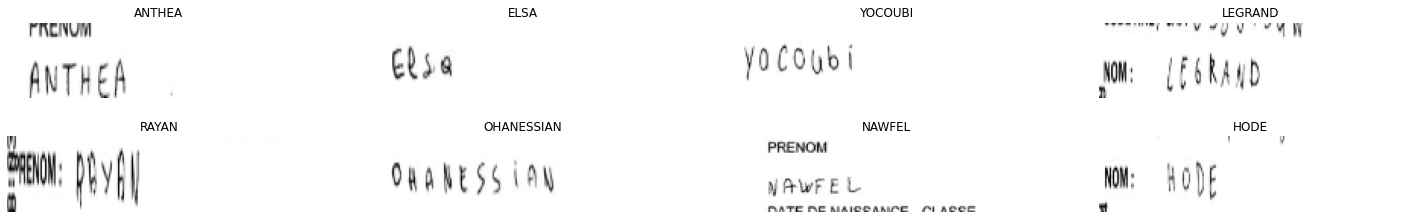

In [18]:
show_images(data=train_ds, cmap='gray')

In [19]:
class CTCLayer(Layer):
    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)

        # define the loss function 
        self.loss_function = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_hat):
        # Get the batch length 
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")

        # get the input and label lengths
        input_len = tf.cast(tf.shape(y_hat)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_len = tf.cast(tf.shape(y_true)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')

        # calculate the loss
        loss = self.loss_function(y_true, y_hat, input_len, label_len) 

        self.add_loss(loss)

        return y_hat

In [20]:

# Input Layer
input_images = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image")

# Labels : These are added for the training purpose.
input_labels = Input(shape=(None, ), name="label")

### Convolutional layers
# layer 1 
conv_1 = Conv2D(64, 3, strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv_1")(input_images)
# layer 2
conv_2 = Conv2D(32, 3, strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv_2")(conv_1)
max_pool_1 = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv_2)
# layer 3
conv_3 = Conv2D(64, 3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal', name="conv_3")(max_pool_1)
conv_4 = Conv2D(32, 3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal', name="conv_4")(conv_3)
max_pool_2 = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv_4)



### Encoding 
reshape = Reshape(target_shape=((IMG_WIDTH//4), (IMG_HEIGHT//4)*32), name="reshape_layer")(max_pool_2)
dense_encoding = Dense(64, kernel_initializer="he_normal", activation="relu", name="enconding_dense")(reshape)
dense_encoding_2 = Dense(64, kernel_initializer="he_normal", activation="relu", name="enconding_dense_2")(dense_encoding)
dropout = Dropout(0.4)(dense_encoding_2)

# Decoder
lstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25), name="bidirectional_lstm_1")(dropout)
lstm_2 = Bidirectional(LSTM(64, return_sequences=True, dropout=0.25), name="bidirectional_lstm_2")(lstm_1)

# Final Output layer
output = Dense(len(char_to_num.get_vocabulary())+1, activation="softmax", name="output_dense")(lstm_2)

# Add the CTC loss 
ctc_loss_layer = CTCLayer()(input_labels, output) 

# Define the final model
model = Model(inputs=[input_images, input_labels], outputs=[ctc_loss_layer])

In [21]:

# draw the model plot
tf.keras.utils.plot_model(
    model,
    to_file='model-graph.png'
)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [22]:
# see the model summary 
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 200, 50, 64)  640         image[0][0]                      
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 200, 50, 32)  18464       conv_1[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 100, 25, 32)  0           conv_2[0][0]                     
_______________________________________________________________________________________

In [23]:
# compile the model
model.compile(optimizer="adam")

In [24]:
# train the model
history = model.fit(train_ds, validation_data=valid_ds, epochs=EPOCHS, callbacks=CALLBACKS)

Epoch 1/150
3000/3000 [==============================] - 913s 304ms/step - loss: 19.9292 - val_loss: 18.7762
Epoch 2/150
3000/3000 [==============================] - 780s 260ms/step - loss: 18.6002 - val_loss: 18.4242
Epoch 3/150
3000/3000 [==============================] - 1001s 334ms/step - loss: 18.3488 - val_loss: 18.2191
Epoch 4/150
3000/3000 [==============================] - 1002s 334ms/step - loss: 18.1089 - val_loss: 17.7569
Epoch 5/150
3000/3000 [==============================] - 886s 295ms/step - loss: 16.9454 - val_loss: 15.1198
Epoch 6/150
3000/3000 [==============================] - 818s 273ms/step - loss: 13.6856 - val_loss: 10.5724
Epoch 7/150
3000/3000 [==============================] - 779s 260ms/step - loss: 8.8124 - val_loss: 6.0692
Epoch 8/150
3000/3000 [==============================] - 764s 255ms/step - loss: 5.9680 - val_loss: 4.2983
Epoch 9/150
3000/3000 [==============================] - 739s 246ms/step - loss: 4.6517 - val_loss: 3.5161
Epoch 10/150
3000/3000 

In [26]:
!pip install seaborn

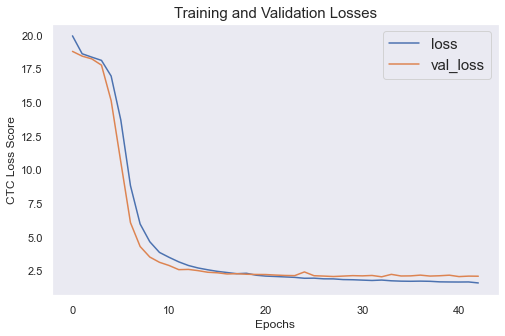

In [27]:
import seaborn as sb
# draw plot for results 
sb.set()
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.legend(fontsize=15)
plt.xlabel("Epochs")
plt.ylabel("CTC Loss Score")
plt.title("Training and Validation Losses", fontsize=15)
plt.grid()
plt.savefig("model_result.png")
plt.show()

In [28]:
# evaluate the model on the test dataset 
evaluation = model.evaluate(test_ds)
print(f"evaluation loss: {evaluation}")

300/300 [==============================] - 19s 63ms/step - loss: 2.1522
evaluation loss: 2.15220046043396


In [29]:
def decoder_prediction(pred_label):
    """
    This function has the job to decode the prediction that the model had.
    The model predicts each character and then this function makes it readable. 
    """
    # Input length
    input_len = np.ones(shape=pred_label.shape[0]) * pred_label.shape[1]
    
    # CTC decode
    decode = tf.keras.backend.ctc_decode(pred_label, input_length=input_len, greedy=True)[0][0][:,:MAX_LABEL_LENGTH]
    
    # Converting numerics back to their character values
    chars = num_to_char(decode)
    
    # Join all the characters
    texts = [tf.strings.reduce_join(inputs=char).numpy().decode('UTF-8') for char in chars]
    
    # Remove the unknown token
    filtered_texts = [text.replace('[UNK]', " ").strip() for text in texts]
    
    return filtered_texts

In [30]:
# define a model for testing and evaluation 
pred_model = Model(inputs=model.get_layer(name="image").input, outputs=model.get_layer(name='output_dense').output)

In [3]:
tf.config.list_physical_devices('GPU')

[]

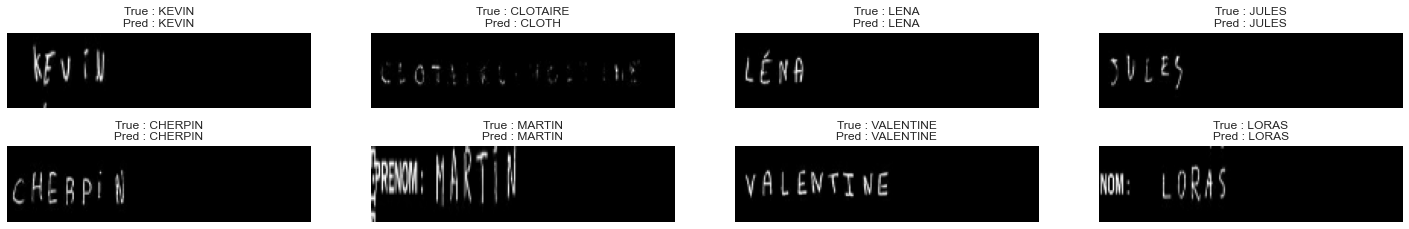

In [31]:
show_images(data=test_ds, model=pred_model, decode_pred=decoder_prediction, cmap='binary')

In [32]:
def single_sample_prediction(model, path):
    """
    This function gets an image path and the model,
    Loads and preprocesses the image and make predictions on it. 
    """
    # load image 
    image_loading = tf.io.read_file(path)
    # decode image 
    decoded_image = tf.image.decode_jpeg(contents=image_loading, channels=1)
    # convert the image data type to float 
    convert_image = tf.image.convert_image_dtype(image=decoded_image, dtype=tf.float32)
    # resize the image 
    resized_image = tf.image.resize(images=convert_image, size=(IMG_HEIGHT, IMG_WIDTH))
    resized_image = tf.transpose(resized_image, perm = [1, 0, 2])
    # convert image to array
    image_array = tf.cast(resized_image, dtype=tf.float32)
    # reshape image 
    single_image_data_with_batch = np.expand_dims(image_array, axis=0)

    # make prediction 
    prediction = decoder_prediction(model.predict(single_image_data_with_batch))

    return prediction 

['HUGO']


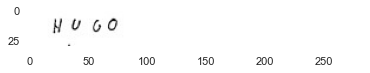

In [33]:
# prediction 1:
img_1_path = "data\\test_v2\\test\\TEST_0179.jpg"
img_1 = implt.imread(img_1_path)
plt.imshow(img_1)
print(single_sample_prediction(pred_model, img_1_path))

['CHAVENON']


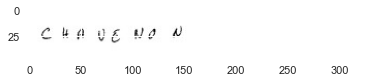

In [34]:
# prediction 2:
img_2_path = "data\\test_v2\\test\\TEST_0274.jpg"
img_2 = implt.imread(img_2_path)
plt.imshow(img_2)
print(single_sample_prediction(pred_model, img_2_path))

['WELCKER']


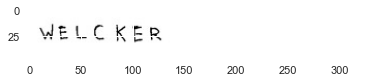

In [35]:
# prediction 3:
img_3_path = "data\\test_v2\\test\\TEST_0684.jpg"
img_3 = implt.imread(img_3_path)
plt.imshow(img_3)
print(single_sample_prediction(pred_model, img_3_path))

In [37]:
# save the model
model.save("model.hd5")
# save weights
model.save_weights("model_weights.hd5")
# Save the model into pickle file

INFO:tensorflow:Assets written to: model.hd5\assets


In [40]:
!pip install keras

In [38]:
tf.__version__

'2.3.0'

In [45]:
# Memuat model dari file HDF5
loaded_model = tf.keras.models.load_model('model.hd5')

# Pastikan model telah dimuat dengan benar
loaded_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 200, 50, 64)  640         image[0][0]                      
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 200, 50, 32)  18464       conv_1[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 100, 25, 32)  0           conv_2[0][0]                     
_______________________________________________________________________________________